In [1]:
#Import libraries
import os
import calendar
import numpy as np
%matplotlib inline
import pandas as pd
from numpy import std
from numpy import cov
import seaborn as sns
from numpy import mean
from scipy import stats
import researchpy as rp
from scipy import stats
import statsmodels.api as sm
from matplotlib import pyplot
from numpy.random import seed
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.utils import shuffle
from scipy.stats import spearmanr
from datetime import datetime as dt
from matplotlib.pyplot import xticks
from scipy.stats import chi2_contingency
from scipy.stats import norm, skew,kurtosis
from sklearn.preprocessing import StandardScaler

#Load data
df = pd.read_excel("RT_CVR.xlsx")

C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Exploratory Data Analysis

In [2]:
#View few rows
df.head(3)

,Acctg_date,Coverage_code,Channel,Creates,Cancels,Completes,Response_time,Conversion_Rate
0,2019-02-01,D2C,MSO,2013,791.0,1215.0,4.421026,0.603577
1,2019-02-01,HW Init,Online,3,NaN,3.0,3.666667,1.000000
2,2019-02-01,HW Init,MSO,343,59.0,280.0,3.843658,0.816327


In [3]:
#Check for missing values
df.isnull().sum()

Acctg_date           0
Coverage_code        0
Channel              0
Creates              0
Cancels            225
Completes           10
Response_time        0
Conversion_Rate     10
dtype: int64

In [4]:
#Calculate percentage of missing values in each column
round(100*(df.isnull().sum()/len(df.index)), 2)

Acctg_date          0.00
Coverage_code       0.00
Channel             0.00
Creates             0.00
Cancels            14.80
Completes           0.66
Response_time       0.00
Conversion_Rate     0.66
dtype: float64

**Data Preprocessing**

In [6]:
df_fill = df.fillna(0)

ds = df_fill.copy()
ds['Year']=ds.Acctg_date.dt.year 
ds['Month']=ds.Acctg_date.dt.month
ds['MonthName'] = ds['Month'].apply(lambda x: calendar.month_name[x])
ds['WeekNumber']=ds.Acctg_date.dt.week

ds['Response_time'] = round(ds['Response_time'],2)
ds['Conversion_Rate'] = round(ds['Conversion_Rate'],2)
grouped_multiple = ds.groupby(['Coverage_code', 'Channel']).agg({'Response_time': ['mean', 'min', 'max']})
grouped_multiple.columns = ['RT_Mean', 'RT_Min', 'RT_Max']
grouped_multiple = grouped_multiple.reset_index()
print(grouped_multiple)

  Coverage_code Channel   RT_Mean  RT_Min  RT_Max
0           D2C     MSO  4.073980    2.10    9.19
1           D2C  Online  3.237583    1.87   11.33
2       HW Init     MSO  3.711841    1.50   13.50
3       HW Init  Online  3.134593    0.00   16.33


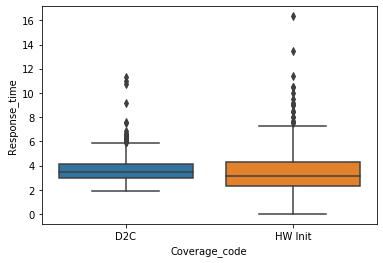

In [6]:
sns.boxplot(y = 'Response_time', x = 'Coverage_code', data = ds)

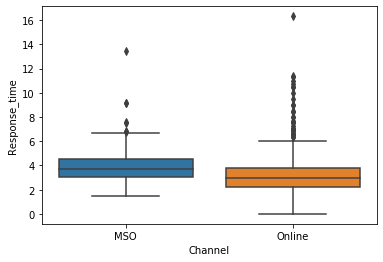

In [7]:
sns.boxplot(y = 'Response_time', x = 'Channel', data = ds)

# Correlation Analysis

C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice
  """
C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


data1: mean=3.55 stdv=1.46
data2: mean=0.75 stdv=0.15
Pearsons correlation: -0.16


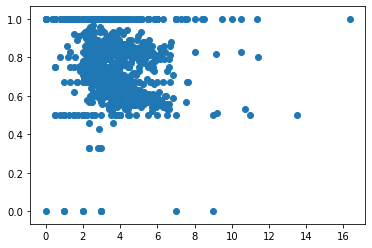

In [8]:
data1 = ds[['Response_time']]
data2 = ds[['Conversion_Rate']]

corr, _ = pearsonr(data1, data2)
covariance = cov(data1, data2)
corr, _ = pearsonr(data1, data2)

print('data1: mean=%.2f stdv=%.2f' % (mean(data1), std(data1)))
print('data2: mean=%.2f stdv=%.2f' % (mean(data2), std(data2)))
print('Pearsons correlation: %.2f' % corr)
# plot
pyplot.scatter(data1, data2)
pyplot.show()

In [7]:
df_grp = ds.copy()
group = df_grp.groupby(['Year','WeekNumber','Coverage_code','Channel'])
grp = group.aggregate({'Creates':'sum'})
grp['Cancels'] = df_grp.groupby(['Year','WeekNumber','Coverage_code','Channel']).Cancels.sum()
grp['Completes'] = df_grp.groupby(['Year','WeekNumber','Coverage_code','Channel']).Completes.sum()
grp['Response_time'] = df_grp.groupby(['Year','WeekNumber','Coverage_code','Channel']).Response_time.sum()
grp['Conversion_Rate'] = df_grp.groupby(['Year','WeekNumber','Coverage_code','Channel']).Conversion_Rate.mean()
grp.reset_index(drop=False,inplace=True)
grp.head()

,Year,WeekNumber,Coverage_code,Channel,Creates,Cancels,Completes,Response_time,Conversion_Rate
0,2019,1,D2C,MSO,2616,905.0,1708.0,7.32,0.665000
1,2019,1,D2C,Online,1328,397.0,930.0,6.77,0.695000
2,2019,1,HW Init,MSO,65,9.0,56.0,7.99,0.850000
3,2019,1,HW Init,Online,6,1.0,5.0,6.25,0.750000
4,2019,5,D2C,MSO,4381,1687.0,2675.0,12.66,0.613333


In [8]:
rt_mean_max = grp.groupby(['Coverage_code', 'Channel']).agg({'Response_time': ['mean', 'min', 'max']})
rt_mean_max.columns = ['RT_Mean', 'RT_Min', 'RT_Max']
rt_mean_max = rt_mean_max.reset_index()

cvr_mean_max = grp.groupby(['Coverage_code', 'Channel']).agg({'Conversion_Rate': ['mean', 'min', 'max']})
cvr_mean_max.columns = ['CVR_Mean', 'CVR_Min', 'CVR_Max']
cvr_mean_max = cvr_mean_max.reset_index()
print(rt_mean_max),print(cvr_mean_max)

  Coverage_code Channel    RT_Mean  RT_Min  RT_Max
0           D2C     MSO  27.534483    7.32   44.40
1           D2C  Online  21.937414    6.77   36.04
2       HW Init     MSO  25.022931    7.99   43.49
3       HW Init  Online  18.591379    1.00   40.17
  Coverage_code Channel  CVR_Mean   CVR_Min   CVR_Max
0           D2C     MSO  0.636925  0.543333  0.701429
1           D2C  Online  0.672710  0.564286  0.722857
2       HW Init     MSO  0.841716  0.740000  0.941429
3       HW Init  Online  0.847233  0.625000  1.000000


(None, None)

In [9]:
rt_mean_max.to_excel('rt_mean_max.xlsx', index=False)

In [10]:
cvr_mean_max.to_excel('cvr_mean_max.xlsx', index=False)

C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


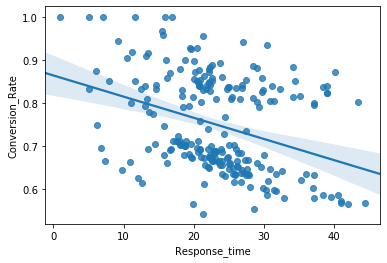

In [11]:
ax = sns.regplot(x="Response_time", y="Conversion_Rate", data=grp)

C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice
  """
C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


RT: mean=23.27 stdv=7.84
CVR: mean=0.75 stdv=0.11
Pearsons correlation: -0.35


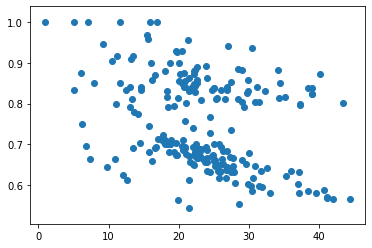

In [12]:
RT = grp[['Response_time']]
CVR = grp[['Conversion_Rate']]

corr, _ = pearsonr(RT, CVR)
covariance = cov(RT, CVR)
corr, _ = pearsonr(RT, CVR)

print('RT: mean=%.2f stdv=%.2f' % (mean(RT), std(RT)))
print('CVR: mean=%.2f stdv=%.2f' % (mean(CVR), std(CVR)))
print('Pearsons correlation: %.2f' % corr)
# plot
pyplot.scatter(RT, CVR)
pyplot.show()

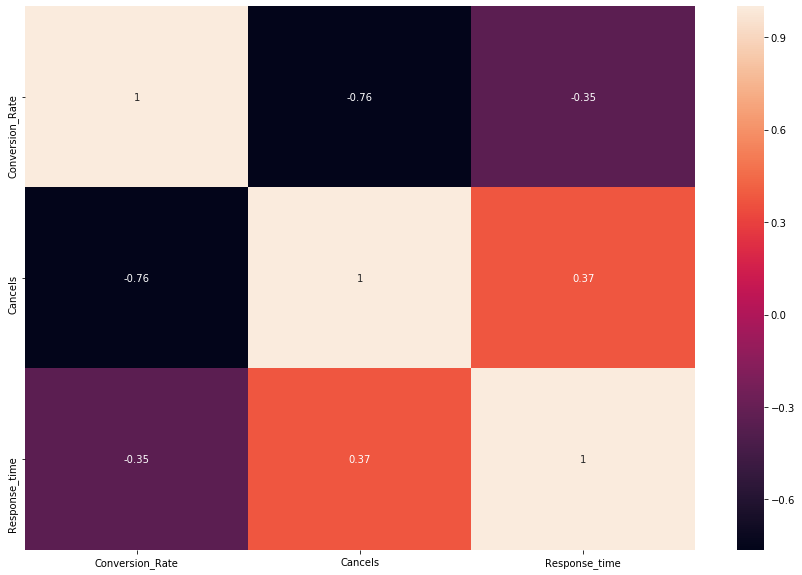

In [13]:
df_corr = grp[['Conversion_Rate', 'Cancels', 'Response_time']]
plt.figure(figsize=(15, 10))
sns.heatmap(df_corr.corr(), annot=True)

# Correlation Result - Overall (MSO & Online) 
Response Time (RT) and Coversion Rate has a weak (negative) linear relationship (-0.35).

In [14]:
d2c_mso = (grp[grp["Coverage_code"].isin(["D2C"]) & grp["Channel"].isin(["MSO"])])
hw_mso = (grp[grp["Coverage_code"].isin(["HW Init"]) & grp["Channel"].isin(["MSO"])])
d2c_online = (grp[grp["Coverage_code"].isin(["D2C"]) & grp["Channel"].isin(["Online"])])
hw_online = (grp[grp["Coverage_code"].isin(["HW Init"]) & grp["Channel"].isin(["Online"])])

In [17]:
d2c_mso[['Conversion_Rate', 'Cancels', 'Response_time']].corr()

,Conversion_Rate,Cancels,Response_time
Conversion_Rate,1.000000,-0.580024,-0.617780
Cancels,-0.580024,1.000000,0.328706
Response_time,-0.617780,0.328706,1.000000


In [18]:
hw_mso[['Conversion_Rate', 'Cancels', 'Response_time']].corr()

,Conversion_Rate,Cancels,Response_time
Conversion_Rate,1.000000,-0.211011,-0.222317
Cancels,-0.211011,1.000000,0.222033
Response_time,-0.222317,0.222033,1.000000


In [19]:
d2c_online[['Conversion_Rate', 'Cancels', 'Response_time']].corr()

,Conversion_Rate,Cancels,Response_time
Conversion_Rate,1.000000,-0.775498,-0.642225
Cancels,-0.775498,1.000000,0.660502
Response_time,-0.642225,0.660502,1.000000


In [20]:
hw_online[['Conversion_Rate', 'Cancels', 'Response_time']].corr()

,Conversion_Rate,Cancels,Response_time
Conversion_Rate,1.000000,-0.634363,-0.235550
Cancels,-0.634363,1.000000,0.612563
Response_time,-0.235550,0.612563,1.000000


C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice
  """
C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


RT: mean=27.53 stdv=7.19
CVR: mean=0.64 stdv=0.04
Pearsons correlation: -0.62


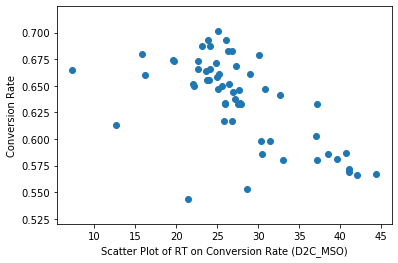

In [21]:
RT = d2c_mso[['Response_time']]
CVR = d2c_mso[['Conversion_Rate']]

corr, _ = pearsonr(RT, CVR)
covariance = cov(RT, CVR)
corr, _ = pearsonr(RT, CVR)

print('RT: mean=%.2f stdv=%.2f' % (mean(RT), std(RT)))
print('CVR: mean=%.2f stdv=%.2f' % (mean(CVR), std(CVR)))
print('Pearsons correlation: %.2f' % corr)
# plot

plt.xlabel("Scatter Plot of RT on Conversion Rate (D2C_MSO)")
plt.ylabel("Conversion Rate")

pyplot.scatter(RT, CVR)
pyplot.show()

RT: mean=25.02 stdv=7.08
CVR: mean=0.84 stdv=0.03
Pearsons correlation: -0.22


C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice
  """
C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


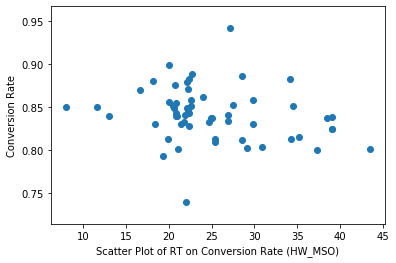

In [33]:
RT = hw_mso[['Response_time']]
CVR = hw_mso[['Conversion_Rate']]

corr, _ = pearsonr(RT, CVR)
covariance = cov(RT, CVR)
corr, _ = pearsonr(RT, CVR)

print('RT: mean=%.2f stdv=%.2f' % (mean(RT), std(RT)))
print('CVR: mean=%.2f stdv=%.2f' % (mean(CVR), std(CVR)))
print('Pearsons correlation: %.2f' % corr)
# plot

plt.xlabel("Scatter Plot of RT on Conversion Rate (HW_MSO)")
plt.ylabel("Conversion Rate")

pyplot.scatter(RT, CVR)
pyplot.show()

C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


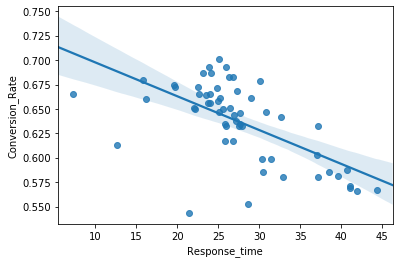

In [22]:
ax = sns.regplot(x="Response_time", y="Conversion_Rate", data=d2c_mso)

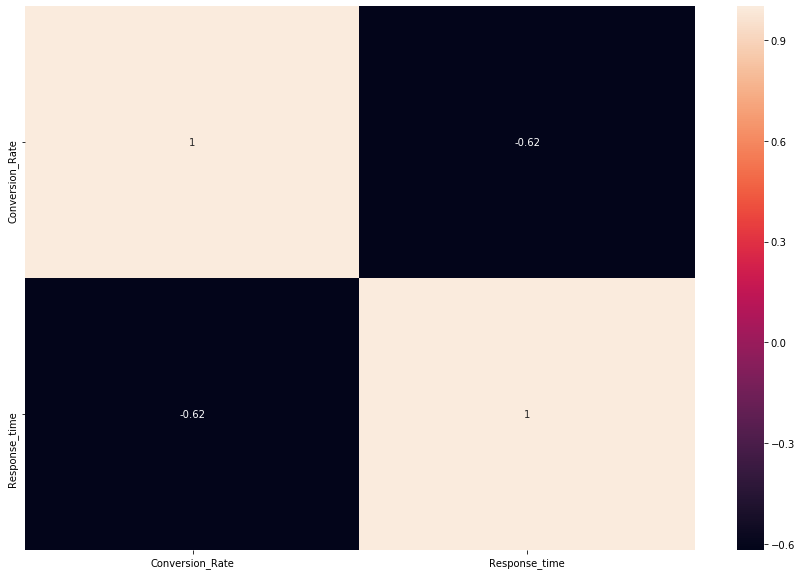

In [23]:
df_corr = d2c_mso[['Conversion_Rate', 'Response_time']]
plt.figure(figsize=(15, 10))
sns.heatmap(df_corr.corr(), annot=True)

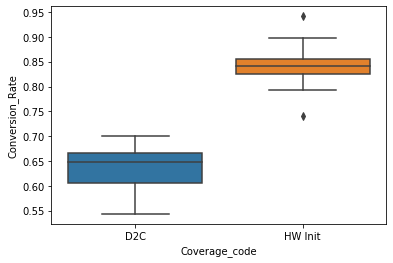

In [31]:
mso = grp[grp["Channel"].isin(["MSO"])]
sns.boxplot(y = 'Conversion_Rate', x = 'Coverage_code', data = mso)

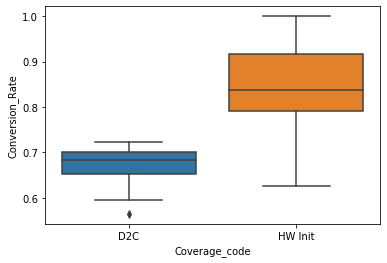

In [25]:
online = grp[grp["Channel"].isin(["Online"])]
sns.boxplot(y = 'Conversion_Rate', x = 'Coverage_code', data = online)

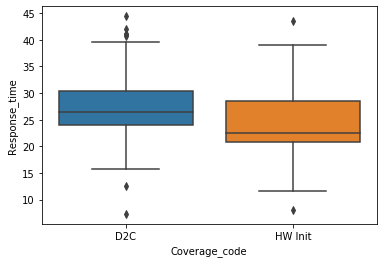

In [26]:
sns.boxplot(y = 'Response_time', x = 'Coverage_code', data = mso)

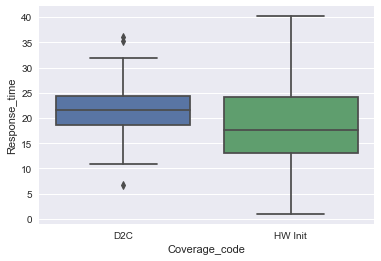

In [45]:
sns.boxplot(y = 'Response_time', x = 'Coverage_code', data = online)

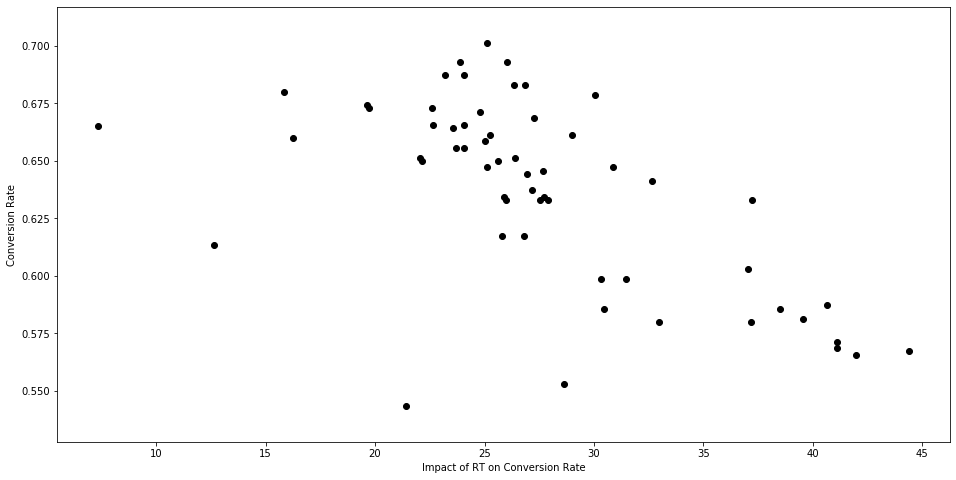

In [27]:
plt.figure(figsize=(16, 8))
plt.scatter(
    d2c_mso['Response_time'],
    d2c_mso['Conversion_Rate'],
    c='black'
)
plt.xlabel("Impact of RT on Conversion Rate")
plt.ylabel("Conversion Rate")
plt.show()

# Build Models

In [50]:
d2c_mso.head()

,Year,WeekNumber,Coverage_code,Channel,Creates,Cancels,Completes,Response_time,Conversion_Rate
0,2019,1,D2C,MSO,2616,905.0,1708.0,7.32,0.665000
4,2019,5,D2C,MSO,4381,1687.0,2675.0,12.66,0.613333
8,2019,6,D2C,MSO,13136,4638.0,8447.0,27.19,0.637143
12,2019,7,D2C,MSO,12592,4353.0,8200.0,26.93,0.644286
16,2019,8,D2C,MSO,11998,4164.0,7811.0,25.12,0.647143


In [66]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

data = d2c_mso[['Conversion_Rate', 'Cancels', 'Response_time', 'Creates', 'Completes']]
def forward_selected(data, response):
 
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

model = forward_selected(data, 'Conversion_Rate')
print(model.model.formula),print(model.params)

Conversion_Rate ~ Response_time + Cancels + Completes + Creates + 1
Intercept        0.675038
Response_time   -0.000819
Cancels          0.000294
Completes        0.000383
Creates         -0.000352
dtype: float64


(None, None)

In [58]:
print(model.rsquared),print(model.rsquared_adj)

0.5409614635245156
0.5242691531072252


(None, None)

In [59]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Conversion_Rate   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     32.41
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           5.02e-10
Time:                        15:49:33   Log-Likelihood:                 126.54
No. Observations:                  58   AIC:                            -247.1
Df Residuals:                      55   BIC:                            -240.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7496      0.015     49.621

In [67]:
#Add more variables
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Conversion_Rate   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     174.4
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           8.03e-30
Time:                        15:57:56   Log-Likelihood:                 180.83
No. Observations:                  58   AIC:                            -351.7
Df Residuals:                      53   BIC:                            -341.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6750      0.008     88.917

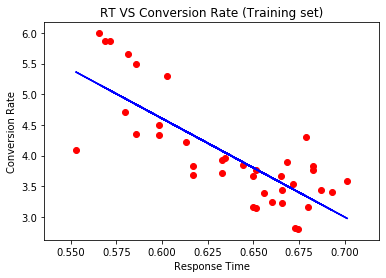

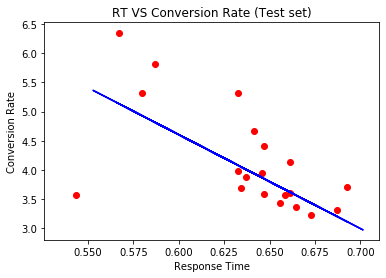

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score,r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor

dataset = d2c_mso[['Conversion_Rate', 'Response_time']]
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, 1]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)

# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Visualizing the Training set results
viz_train = plt
viz_train.scatter(X_train, y_train, color='red')
viz_train.plot(X_train, regressor.predict(X_train), color='blue')
viz_train.title('RT VS Conversion Rate (Training set)')
viz_train.xlabel('Response Time')
viz_train.ylabel('Conversion Rate')
viz_train.show()

# Visualizing the Test set results
viz_test = plt
viz_test.scatter(X_test, y_test, color='red')
viz_test.plot(X_train, regressor.predict(X_train), color='blue')
viz_test.title('RT VS Conversion Rate (Test set)')
viz_test.xlabel('Response Time')
viz_test.ylabel('Conversion Rate')
viz_test.show()

In [73]:
accuracy_lr = regressor.score(X_test, y_test)
print(accuracy_lr)

0.23612267182270075


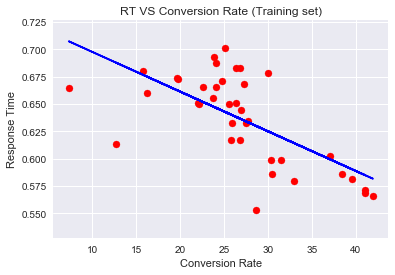

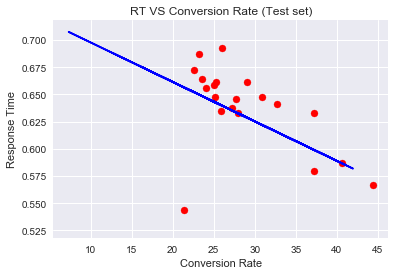

In [75]:
dataset = d2c_mso[['Response_time','Conversion_Rate']]
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, 1]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)

# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor_1 = LinearRegression()
regressor_1.fit(X_train, y_train)

# Visualizing the Training set results
viz_train = plt
viz_train.scatter(X_train, y_train, color='red')
viz_train.plot(X_train, regressor.predict(X_train), color='blue')
viz_train.title('RT VS Conversion Rate (Training set)')
viz_train.xlabel('Conversion Rate')
viz_train.ylabel('Response Time')
viz_train.show()

# Visualizing the Test set results
viz_test = plt
viz_test.scatter(X_test, y_test, color='red')
viz_test.plot(X_train, regressor.predict(X_train), color='blue')
viz_test.title('RT VS Conversion Rate (Test set)')
viz_test.xlabel('Conversion Rate')
viz_test.ylabel('Response Time')
viz_test.show()

In [76]:
accuracy_lr2 = regressor_1.score(X_test, y_test)
print(accuracy_lr2)

0.23612267182270075


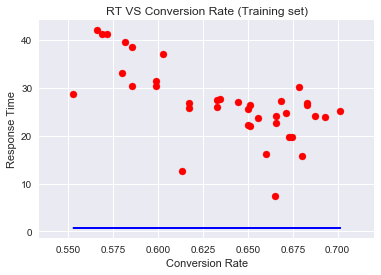

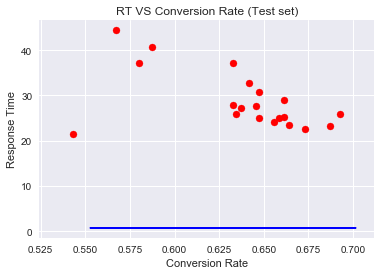

In [77]:
dataset = d2c_mso[['Conversion_Rate', 'Response_time']]
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)

model2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=42)
model2.fit(X_train, y_train)

# Visualizing the Training set results
viz_train = plt
viz_train.scatter(X_train, y_train, color='red')
viz_train.plot(X_train, regressor.predict(X_train), color='blue')
viz_train.title('RT VS Conversion Rate (Training set)')
viz_train.xlabel('Conversion Rate')
viz_train.ylabel('Response Time')
viz_train.show()

# Visualizing the Test set results
viz_test = plt
viz_test.scatter(X_test, y_test, color='red')
viz_test.plot(X_train, regressor.predict(X_train), color='blue')
viz_test.title('RT VS Conversion Rate (Test set)')
viz_test.xlabel('Conversion Rate')
viz_test.ylabel('Response Time')
viz_test.show()

In [78]:
accuracy_AdaBoost = model2.score(X_test, y_test)
print(accuracy_AdaBoost)

-0.22259238100679202


In [80]:
# Ordinary least squares (OLS) Algorithm
modelfit = smf.ols(formula='Conversion_Rate ~ Response_time+Cancels',data=d2c_mso).fit()

print(modelfit.summary())

                            OLS Regression Results                            
Dep. Variable:        Conversion_Rate   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     32.41
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           5.02e-10
Time:                        16:47:54   Log-Likelihood:                 126.54
No. Observations:                  58   AIC:                            -247.1
Df Residuals:                      55   BIC:                            -240.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7496      0.015     49.621

In [83]:
# Linear Regression Model
X = d2c_mso['Response_time'].values.reshape(-1,1)
y = d2c_mso['Conversion_Rate'].values.reshape(-1,1)
reg = LinearRegression()
reg.fit(X, y)
print("The linear model is: CVR = {:.5} + {:.5}RT".format(reg.intercept_[0], reg.coef_[0][0]))

The linear model is: CVR = 0.73231 + -0.0034642RT


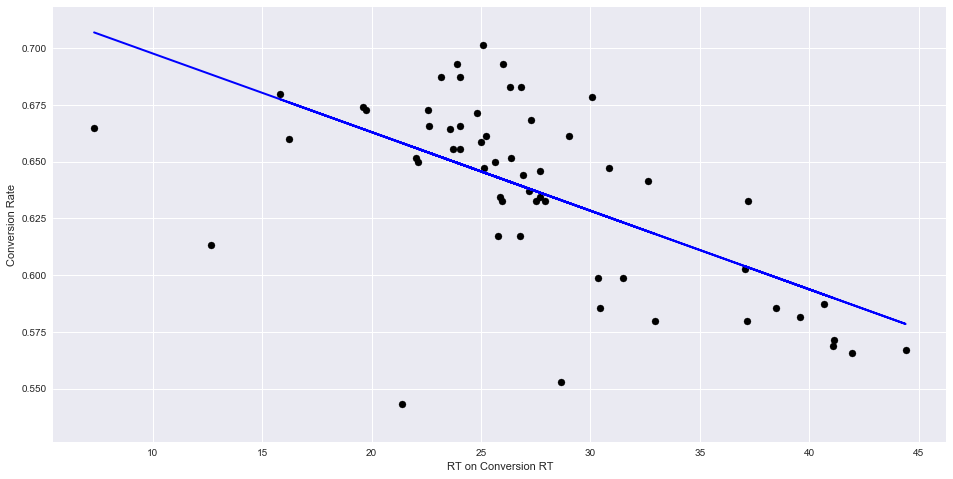

In [84]:
# Visualize how the line fits the data
predictions = reg.predict(X)
plt.figure(figsize=(16, 8))
plt.scatter(
    d2c_mso['Response_time'],
    d2c_mso['Conversion_Rate'],
    c='black'
)
plt.plot(
    d2c_mso['Response_time'],
    predictions,
    c='blue',
    linewidth=2
)
plt.xlabel("RT on Conversion RT")
plt.ylabel("Conversion Rate")
plt.show()

In [85]:
#Assessing the relevancy of the model
X = d2c_mso['Response_time']
y = d2c_mso['Conversion_Rate']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        Conversion_Rate   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     34.56
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           2.39e-07
Time:                        17:02:38   Log-Likelihood:                 117.90
No. Observations:                  58   AIC:                            -231.8
Df Residuals:                      56   BIC:                            -227.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7323      0.017     43.673

# Interpretation of Results:
The regression output above shows that the Conversion Rate and Response Time variables are statistically significant because their p-values equal 0.000. This means that there is a strong correlation between these coefficients and the target (Conversion Rate). 
The sign of a regression coefficient tells you whether there is a positive or negative correlation between each independent variable the dependent variable.
A negative coefficient suggests that as the independent variable (RT) increases, the dependent variable (CVR) tends to decrease.

In [86]:
X = hw_mso['Response_time']
y = hw_mso['Conversion_Rate']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        Conversion_Rate   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     2.912
Date:                Thu, 18 Jun 2020   Prob (F-statistic):             0.0935
Time:                        17:25:58   Log-Likelihood:                 120.77
No. Observations:                  58   AIC:                            -237.5
Df Residuals:                      56   BIC:                            -233.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8660      0.015     58.474

In [28]:
X = d2c_online['Response_time']
y = d2c_online['Conversion_Rate']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        Conversion_Rate   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     39.31
Date:                Fri, 19 Jun 2020   Prob (F-statistic):           5.51e-08
Time:                        11:07:37   Log-Likelihood:                 127.83
No. Observations:                  58   AIC:                            -251.7
Df Residuals:                      56   BIC:                            -247.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7639      0.015     51.023

In [29]:
X = hw_online['Response_time']
y = hw_online['Conversion_Rate']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        Conversion_Rate   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     3.290
Date:                Fri, 19 Jun 2020   Prob (F-statistic):             0.0751
Time:                        11:08:13   Log-Likelihood:                 56.467
No. Observations:                  58   AIC:                            -108.9
Df Residuals:                      56   BIC:                            -104.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8963      0.030     30.195

In [11]:
df_grp = ds.copy()
group = df_grp.groupby(['Year','WeekNumber','Coverage_code','Channel'])
grp = group.aggregate({'Creates':'sum'})
grp['Cancels'] = df_grp.groupby(['Year','WeekNumber','Coverage_code','Channel']).Cancels.sum()
grp['Completes'] = df_grp.groupby(['Year','WeekNumber','Coverage_code','Channel']).Completes.sum()
grp['Response_time'] = df_grp.groupby(['Year','WeekNumber','Coverage_code','Channel']).Response_time.mean()
grp['Conversion_Rate'] = df_grp.groupby(['Year','WeekNumber','Coverage_code','Channel']).Conversion_Rate.mean()
grp.reset_index(drop=False,inplace=True)
grp.head(3)

,Year,WeekNumber,Coverage_code,Channel,Creates,Cancels,Completes,Response_time,Conversion_Rate
0,2019,1,D2C,MSO,2616,905.0,1708.0,3.660,0.665
1,2019,1,D2C,Online,1328,397.0,930.0,3.385,0.695
2,2019,1,HW Init,MSO,65,9.0,56.0,3.995,0.850


In [12]:
rt_mean_max = grp.groupby(['Coverage_code', 'Channel']).agg({'Response_time': ['mean', 'min', 'max']})
rt_mean_max.columns = ['RT_Mean', 'RT_Min', 'RT_Max']
rt_mean_max = rt_mean_max.reset_index()

cvr_mean_max = grp.groupby(['Coverage_code', 'Channel']).agg({'Conversion_Rate': ['mean', 'min', 'max']})
cvr_mean_max.columns = ['CVR_Mean', 'CVR_Min', 'CVR_Max']
cvr_mean_max = cvr_mean_max.reset_index()
print(rt_mean_max),print(cvr_mean_max)

  Coverage_code Channel   RT_Mean    RT_Min    RT_Max
0           D2C     MSO  4.060523  2.801429  6.342857
1           D2C  Online  3.239222  2.377143  5.148571
2       HW Init     MSO  3.708314  2.588571  6.212857
3       HW Init  Online  3.050572  1.000000  5.738571
  Coverage_code Channel  CVR_Mean   CVR_Min   CVR_Max
0           D2C     MSO  0.636925  0.543333  0.701429
1           D2C  Online  0.672710  0.564286  0.722857
2       HW Init     MSO  0.841716  0.740000  0.941429
3       HW Init  Online  0.847233  0.625000  1.000000


(None, None)

C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


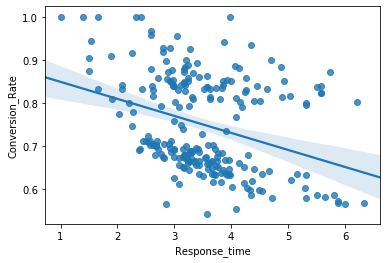

In [10]:
ax = sns.regplot(x="Response_time", y="Conversion_Rate", data=grp)

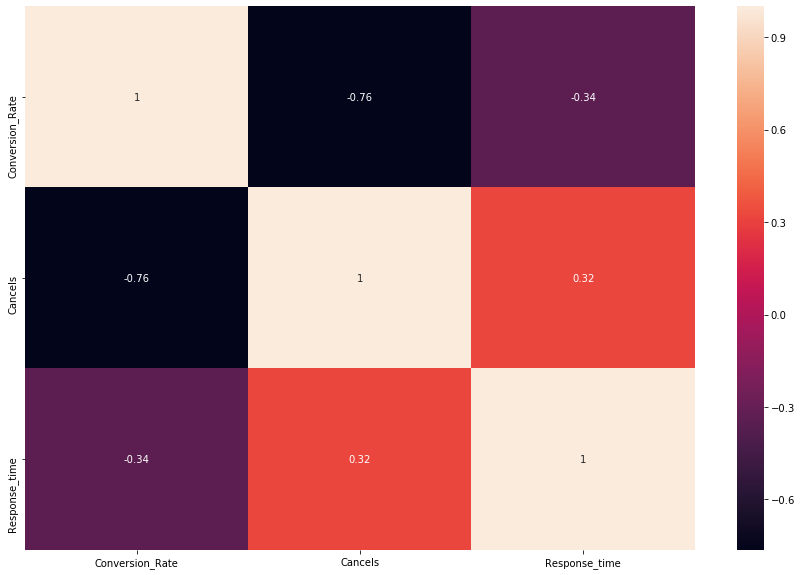

In [12]:
df_corr = grp[['Conversion_Rate', 'Cancels', 'Response_time']]
plt.figure(figsize=(15, 10))
sns.heatmap(df_corr.corr(), annot=True)

In [9]:
d2c_mso = (grp[grp["Coverage_code"].isin(["D2C"]) & grp["Channel"].isin(["MSO"])])
hw_mso = (grp[grp["Coverage_code"].isin(["HW Init"]) & grp["Channel"].isin(["MSO"])])
d2c_online = (grp[grp["Coverage_code"].isin(["D2C"]) & grp["Channel"].isin(["Online"])])
hw_online = (grp[grp["Coverage_code"].isin(["HW Init"]) & grp["Channel"].isin(["Online"])])

In [14]:
d2c_mso[['Conversion_Rate', 'Cancels', 'Response_time']].corr()

,Conversion_Rate,Cancels,Response_time
Conversion_Rate,1.000000,-0.580024,-0.726131
Cancels,-0.580024,1.000000,0.206634
Response_time,-0.726131,0.206634,1.000000


In [15]:
hw_mso[['Conversion_Rate', 'Cancels', 'Response_time']].corr()

,Conversion_Rate,Cancels,Response_time
Conversion_Rate,1.000000,-0.211011,-0.224057
Cancels,-0.211011,1.000000,0.121163
Response_time,-0.224057,0.121163,1.000000


In [16]:
d2c_online[['Conversion_Rate', 'Cancels', 'Response_time']].corr()

,Conversion_Rate,Cancels,Response_time
Conversion_Rate,1.000000,-0.775498,-0.702552
Cancels,-0.775498,1.000000,0.498904
Response_time,-0.702552,0.498904,1.000000


In [17]:
hw_online[['Conversion_Rate', 'Cancels', 'Response_time']].corr()

,Conversion_Rate,Cancels,Response_time
Conversion_Rate,1.000000,-0.634363,-0.286779
Cancels,-0.634363,1.000000,0.465784
Response_time,-0.286779,0.465784,1.000000


C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice
  """
C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


RT: mean=4.06 stdv=0.86
CVR: mean=0.64 stdv=0.04
Pearsons correlation: -0.73


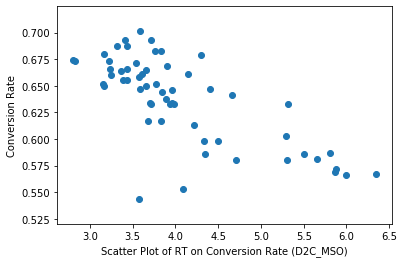

In [10]:
RT = d2c_mso[['Response_time']]
CVR = d2c_mso[['Conversion_Rate']]

corr, _ = pearsonr(RT, CVR)
covariance = cov(RT, CVR)
corr, _ = pearsonr(RT, CVR)

print('RT: mean=%.2f stdv=%.2f' % (mean(RT), std(RT)))
print('CVR: mean=%.2f stdv=%.2f' % (mean(CVR), std(CVR)))
print('Pearsons correlation: %.2f' % corr)
# plot

plt.xlabel("Scatter Plot of RT on Conversion Rate (D2C_MSO)")
plt.ylabel("Conversion Rate")

pyplot.scatter(RT, CVR)
pyplot.show()

C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice
  """
C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


RT: mean=3.71 stdv=0.88
CVR: mean=0.84 stdv=0.03
Pearsons correlation: -0.22


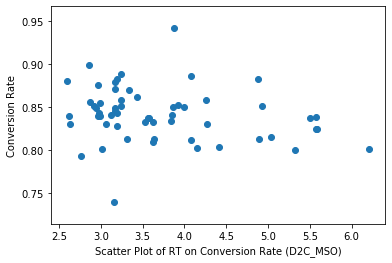

In [11]:
RT = hw_mso[['Response_time']]
CVR = hw_mso[['Conversion_Rate']]

corr, _ = pearsonr(RT, CVR)
covariance = cov(RT, CVR)
corr, _ = pearsonr(RT, CVR)

print('RT: mean=%.2f stdv=%.2f' % (mean(RT), std(RT)))
print('CVR: mean=%.2f stdv=%.2f' % (mean(CVR), std(CVR)))
print('Pearsons correlation: %.2f' % corr)
# plot

plt.xlabel("Scatter Plot of RT on Conversion Rate (D2C_MSO)")
plt.ylabel("Conversion Rate")

pyplot.scatter(RT, CVR)
pyplot.show()

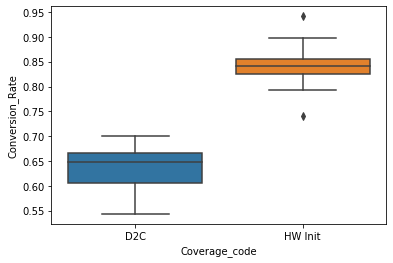

In [19]:
mso = grp[grp["Channel"].isin(["MSO"])]
sns.boxplot(y = 'Conversion_Rate', x = 'Coverage_code', data = mso)

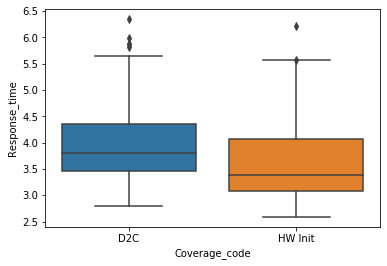

In [20]:
sns.boxplot(y = 'Response_time', x = 'Coverage_code', data = mso)

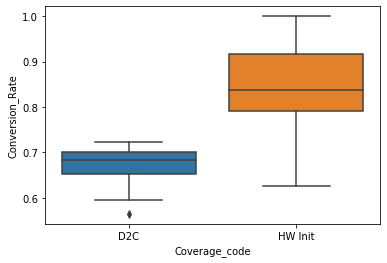

In [21]:
online = grp[grp["Channel"].isin(["Online"])]
sns.boxplot(y = 'Conversion_Rate', x = 'Coverage_code', data = online)

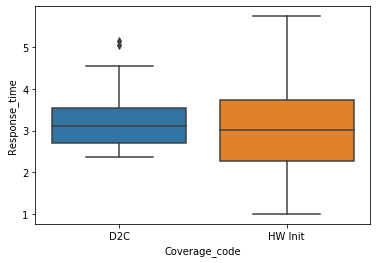

In [22]:
sns.boxplot(y = 'Response_time', x = 'Coverage_code', data = online)

In [25]:
# Linear Regression Model
X = d2c_mso['Response_time'].values.reshape(-1,1)
y = d2c_mso['Conversion_Rate'].values.reshape(-1,1)
reg = LinearRegression()
reg.fit(X, y)
print("The linear model is: CVR = {:.5} + {:.5}RT".format(reg.intercept_[0], reg.coef_[0][0]))

The linear model is: CVR = 0.77569 + -0.034173RT


In [26]:
#Assessing the relevancy of the model
X = d2c_mso['Response_time']
y = d2c_mso['Conversion_Rate']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        Conversion_Rate   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     62.46
Date:                Fri, 19 Jun 2020   Prob (F-statistic):           1.12e-10
Time:                        15:57:22   Log-Likelihood:                 125.69
No. Observations:                  58   AIC:                            -247.4
Df Residuals:                      56   BIC:                            -243.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7757      0.018     43.228

In [27]:
X = hw_mso['Response_time']
y = hw_mso['Conversion_Rate']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        Conversion_Rate   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     2.960
Date:                Fri, 19 Jun 2020   Prob (F-statistic):             0.0909
Time:                        15:58:20   Log-Likelihood:                 120.80
No. Observations:                  58   AIC:                            -237.6
Df Residuals:                      56   BIC:                            -233.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8709      0.017     49.875

In [28]:
X = d2c_online['Response_time']
y = d2c_online['Conversion_Rate']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        Conversion_Rate   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     54.58
Date:                Fri, 19 Jun 2020   Prob (F-statistic):           7.91e-10
Time:                        15:59:35   Log-Likelihood:                 132.14
No. Observations:                  58   AIC:                            -260.3
Df Residuals:                      56   BIC:                            -256.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7946      0.017     47.204

In [29]:
X = hw_online['Response_time']
y = hw_online['Conversion_Rate']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        Conversion_Rate   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     5.018
Date:                Fri, 19 Jun 2020   Prob (F-statistic):             0.0291
Time:                        16:00:02   Log-Likelihood:                 57.300
No. Observations:                  58   AIC:                            -110.6
Df Residuals:                      56   BIC:                            -106.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9275      0.038     24.547